Unconstrained EOQ: [ 48.98979486  94.86832981  67.08203932 100.        ]
Q1=49.0, Q2=94.9, Q3=67.1, Q4=100.0

Constrained optimal: [48 92 64 95]

Unconstrained storage used: 10.39 (limit: 10)
Unconstrained budget used: 184.96 (limit: 500)
Unconstrained cost: $21.009/week

Constrained storage used: 9.96 (limit: 10)
Constrained budget used: 178.80 (limit: 500)
Constrained cost: $21.026/week


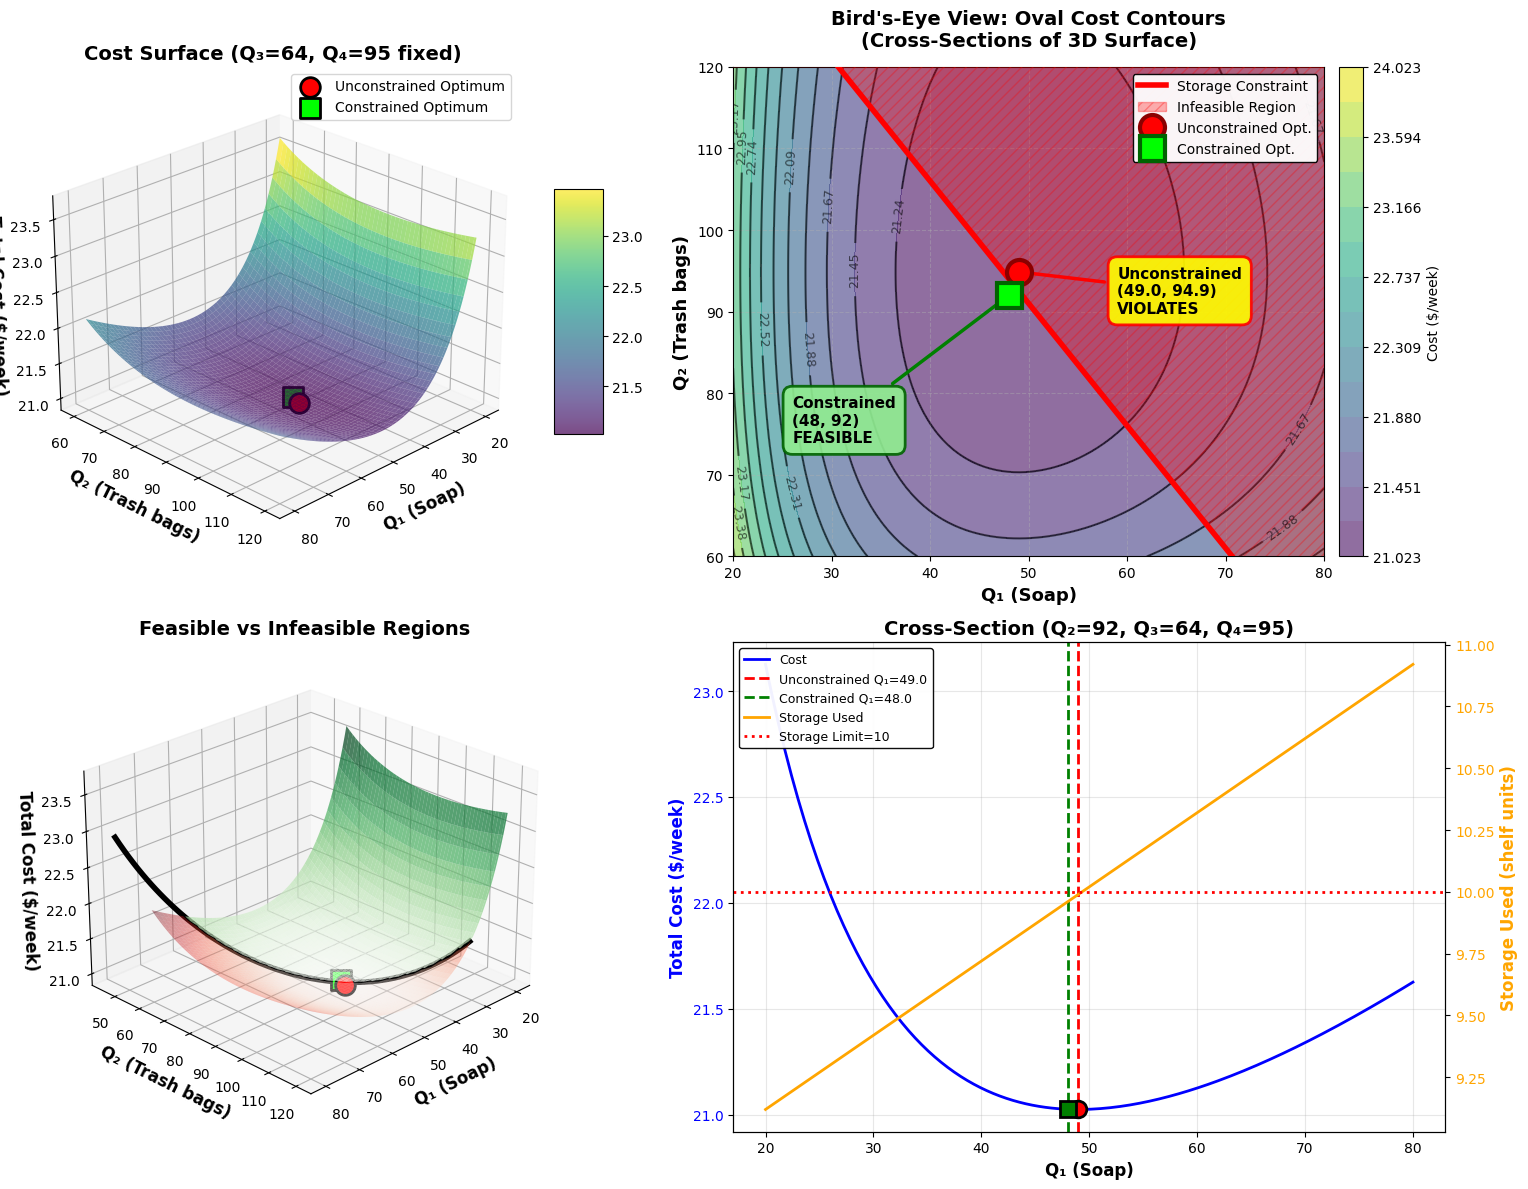

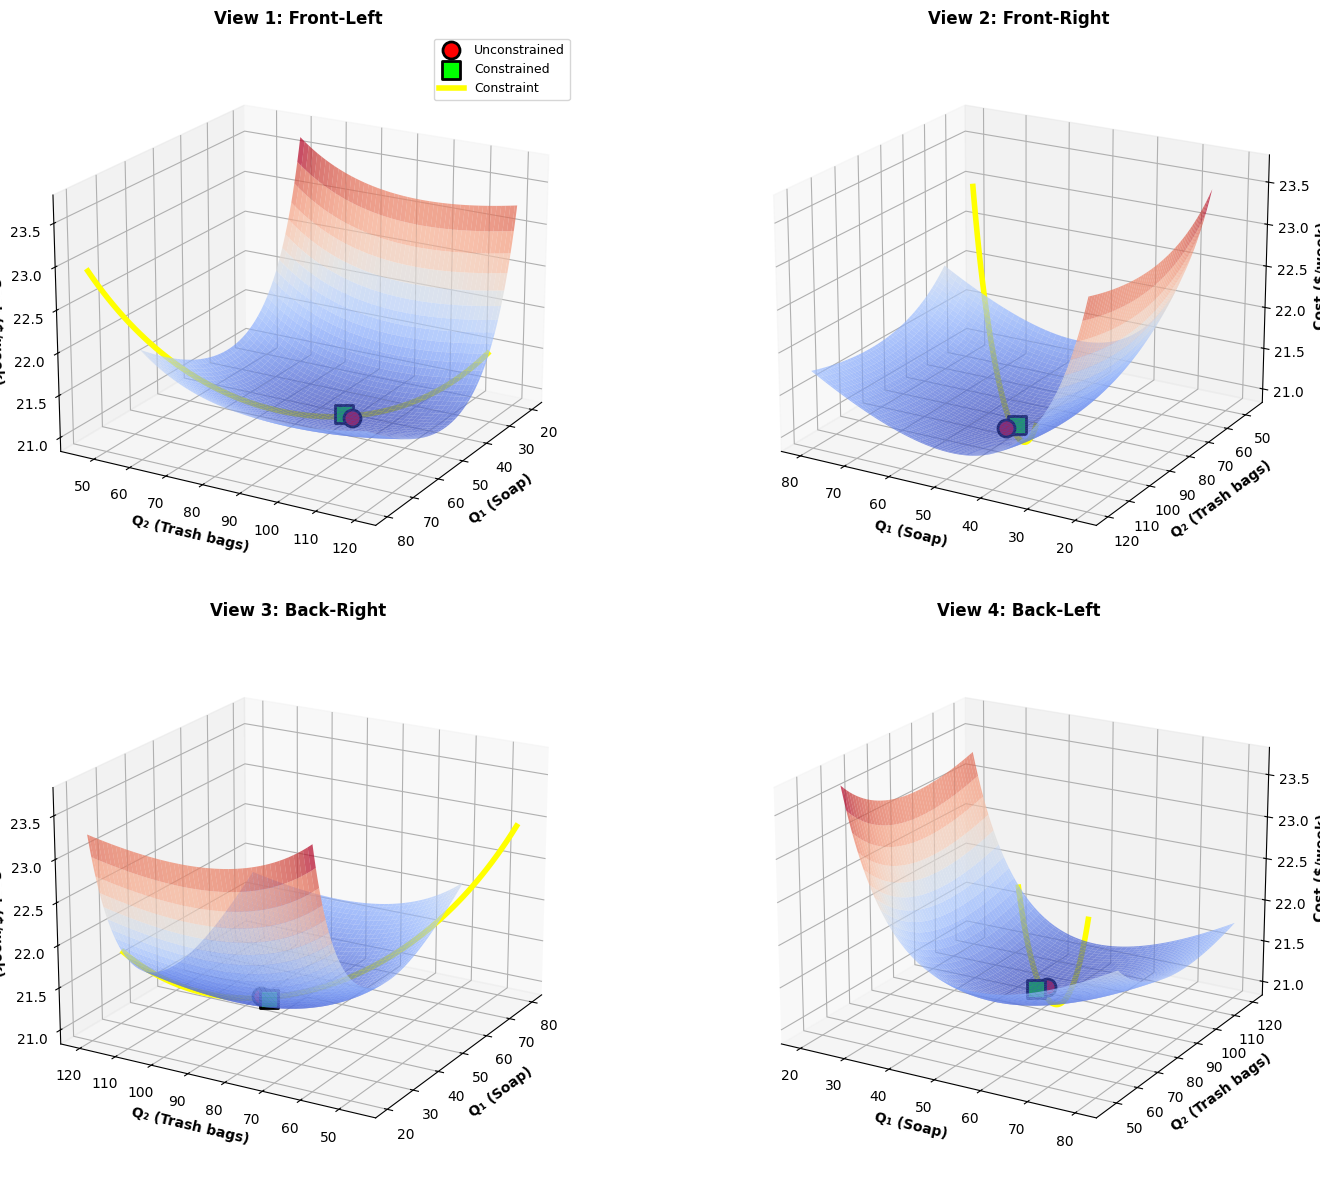

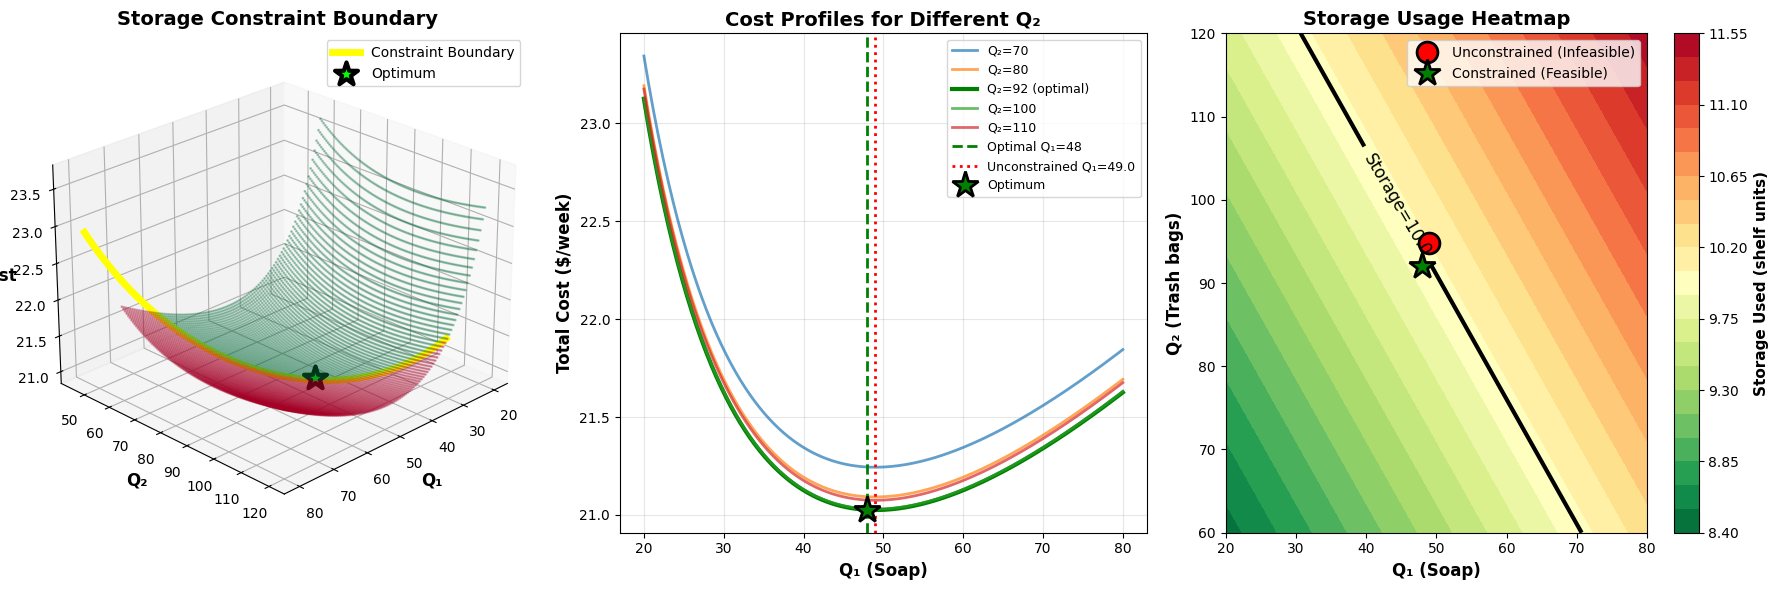

In [5]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Parameters for the 4 items
D = np.array([8, 15, 12, 20])      # Demand per week
K = np.array([15, 15, 15, 15])     # Order cost
h = np.array([0.10, 0.05, 0.08, 0.06])  # Holding cost per unit per week
c = np.array([3.50, 0.40, 1.20, 0.80])  # Unit cost
space = np.array([0.03, 0.02, 0.045, 0.04])  # Shelf units per item
storage_limit = 10  # Total shelf units
budget_limit = 500  # Max inventory value

# Unconstrained optimal solutions (EOQ)
Q_unc = np.sqrt(2 * K * D / h)
print("Unconstrained EOQ:", Q_unc)
print(f"Q1={Q_unc[0]:.1f}, Q2={Q_unc[1]:.1f}, Q3={Q_unc[2]:.1f}, Q4={Q_unc[3]:.1f}")

# Constrained optimal solutions (from Lagrangian)
Q_con = np.array([48, 92, 64, 95])
print("\nConstrained optimal:", Q_con)

# Objective function for all 4 variables
def total_cost_4d(Q1, Q2, Q3, Q4):
    """Calculate total weekly cost for all 4 items"""
    cost = (K[0]*D[0]/Q1 + h[0]*Q1/2 + 
            K[1]*D[1]/Q2 + h[1]*Q2/2 + 
            K[2]*D[2]/Q3 + h[2]*Q3/2 + 
            K[3]*D[3]/Q4 + h[3]*Q4/2)
    return cost

# Storage constraint
def storage_constraint(Q1, Q2, Q3, Q4):
    """Returns how much storage is used"""
    return space[0]*Q1 + space[1]*Q2 + space[2]*Q3 + space[3]*Q4

# Budget constraint
def budget_constraint(Q1, Q2, Q3, Q4):
    """Returns average inventory value"""
    return c[0]*Q1/2 + c[1]*Q2/2 + c[2]*Q3/2 + c[3]*Q4/2

print(f"\nUnconstrained storage used: {storage_constraint(*Q_unc):.2f} (limit: {storage_limit})")
print(f"Unconstrained budget used: {budget_constraint(*Q_unc):.2f} (limit: {budget_limit})")
print(f"Unconstrained cost: ${total_cost_4d(*Q_unc):.3f}/week")

print(f"\nConstrained storage used: {storage_constraint(*Q_con):.2f} (limit: {storage_limit})")
print(f"Constrained budget used: {budget_constraint(*Q_con):.2f} (limit: {budget_limit})")
print(f"Constrained cost: ${total_cost_4d(*Q_con):.3f}/week")

# ============================================================================
# 3D VISUALIZATION: Fix Q3 and Q4 at optimal values, vary Q1 and Q2
# ============================================================================

# Create grid for Q1 and Q2
Q1_range = np.linspace(20, 80, 100)
Q2_range = np.linspace(60, 120, 100)
Q1_grid, Q2_grid = np.meshgrid(Q1_range, Q2_range)

# Fix Q3 and Q4 at their constrained optimal values
Q3_fixed = Q_con[2]  # 64
Q4_fixed = Q_con[3]  # 95

# Calculate cost surface (fixing Q3, Q4)
Cost_grid = np.zeros_like(Q1_grid)
for i in range(Q1_grid.shape[0]):
    for j in range(Q1_grid.shape[1]):
        Cost_grid[i, j] = total_cost_4d(Q1_grid[i, j], Q2_grid[i, j], Q3_fixed, Q4_fixed)

# Calculate constraint values on the grid
Storage_grid = np.zeros_like(Q1_grid)
Budget_grid = np.zeros_like(Q1_grid)
for i in range(Q1_grid.shape[0]):
    for j in range(Q1_grid.shape[1]):
        Storage_grid[i, j] = storage_constraint(Q1_grid[i, j], Q2_grid[i, j], Q3_fixed, Q4_fixed)
        Budget_grid[i, j] = budget_constraint(Q1_grid[i, j], Q2_grid[i, j], Q3_fixed, Q4_fixed)

# ============================================================================
# FIGURE 1: 3D Surface with constraints
# ============================================================================

fig = plt.figure(figsize=(16, 12))

# Subplot 1: Cost surface with constraint boundary
ax1 = fig.add_subplot(221, projection='3d')

# Plot cost surface
surf = ax1.plot_surface(Q1_grid, Q2_grid, Cost_grid, cmap=cm.viridis, 
                        alpha=0.7, edgecolor='none')

# Mark unconstrained optimum (Q3, Q4 fixed at optimal)
unc_cost = total_cost_4d(Q_unc[0], Q_unc[1], Q3_fixed, Q4_fixed)
ax1.scatter([Q_unc[0]], [Q_unc[1]], [unc_cost], 
           color='red', s=200, marker='o', label='Unconstrained Optimum', 
           edgecolor='black', linewidth=2)

# Mark constrained optimum
con_cost = total_cost_4d(Q_con[0], Q_con[1], Q3_fixed, Q4_fixed)
ax1.scatter([Q_con[0]], [Q_con[1]], [con_cost], 
           color='lime', s=200, marker='s', label='Constrained Optimum',
           edgecolor='black', linewidth=2)

ax1.set_xlabel('Q₁ (Soap)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Q₂ (Trash bags)', fontsize=12, fontweight='bold')
ax1.set_zlabel('Total Cost ($/week)', fontsize=12, fontweight='bold')
ax1.set_title(f'Cost Surface (Q₃={Q3_fixed}, Q₄={Q4_fixed} fixed)', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.view_init(elev=25, azim=45)
fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)

# Subplot 2: Bird's-eye view with oval contours (level sets)
ax2 = fig.add_subplot(222)

# Plot oval contours of cost function (level sets)
# Use more levels for better oval visualization
cost_levels = np.linspace(Cost_grid.min(), Cost_grid.min() + 3, 15)
contour = ax2.contour(Q1_grid, Q2_grid, Cost_grid, levels=cost_levels, 
                     colors='black', linewidths=1.5, alpha=0.6)
ax2.clabel(contour, inline=True, fontsize=9, fmt='%.2f')

# Filled contours for better visualization
contourf = ax2.contourf(Q1_grid, Q2_grid, Cost_grid, levels=cost_levels, 
                       cmap='viridis', alpha=0.6)

# Storage constraint boundary
# 0.03*Q1 + 0.02*Q2 + 0.045*Q3 + 0.04*Q4 = 10
# Solving for Q2: Q2 = (10 - 0.03*Q1 - 0.045*Q3_fixed - 0.04*Q4_fixed) / 0.02
storage_remaining = storage_limit - space[2]*Q3_fixed - space[3]*Q4_fixed
Q2_storage_boundary = (storage_remaining - space[0]*Q1_range) / space[1]
valid_storage = Q2_storage_boundary >= 0
ax2.plot(Q1_range[valid_storage], Q2_storage_boundary[valid_storage], 
        'r-', linewidth=4, label='Storage Constraint', zorder=5)

# Shade infeasible region (above storage line)
ax2.fill_between(Q1_range[valid_storage], Q2_storage_boundary[valid_storage], 
                 120, alpha=0.3, color='red', hatch='///', 
                 label='Infeasible Region', zorder=3)

# Mark optimal points with larger markers
ax2.plot(Q_unc[0], Q_unc[1], 'o', color='red', markersize=18, 
        label='Unconstrained Opt.', markeredgecolor='darkred', 
        markeredgewidth=3, zorder=10)
ax2.plot(Q_con[0], Q_con[1], 's', color='lime', markersize=18, 
        label='Constrained Opt.', markeredgecolor='darkgreen', 
        markeredgewidth=3, zorder=10)

# Draw arrow showing movement from unconstrained to constrained
ax2.annotate('', xy=(Q_con[0], Q_con[1]), xytext=(Q_unc[0], Q_unc[1]),
            arrowprops=dict(arrowstyle='->', lw=3, color='white', 
                          shrinkA=10, shrinkB=10))
ax2.annotate('', xy=(Q_con[0], Q_con[1]), xytext=(Q_unc[0], Q_unc[1]),
            arrowprops=dict(arrowstyle='->', lw=2, color='black', 
                          shrinkA=10, shrinkB=10))

# Add annotations
ax2.annotate(f'Unconstrained\n({Q_unc[0]:.1f}, {Q_unc[1]:.1f})\nVIOLATES', 
            xy=(Q_unc[0], Q_unc[1]), xytext=(Q_unc[0]+10, Q_unc[1]-5),
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.6', facecolor='yellow', 
                     edgecolor='red', linewidth=2, alpha=0.9),
            arrowprops=dict(arrowstyle='->', lw=2.5, color='red'))

ax2.annotate(f'Constrained\n({Q_con[0]}, {Q_con[1]})\nFEASIBLE', 
            xy=(Q_con[0], Q_con[1]), xytext=(Q_con[0]-22, Q_con[1]-18),
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.6', facecolor='lightgreen', 
                     edgecolor='darkgreen', linewidth=2, alpha=0.9),
            arrowprops=dict(arrowstyle='->', lw=2.5, color='green'))

ax2.set_xlabel('Q₁ (Soap)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Q₂ (Trash bags)', fontsize=13, fontweight='bold')
ax2.set_title("Bird's-Eye View: Oval Cost Contours\n(Cross-Sections of 3D Surface)", 
             fontsize=14, fontweight='bold', pad=15)
ax2.legend(fontsize=10, loc='upper right', framealpha=0.95, 
          edgecolor='black', fancybox=True)
ax2.grid(True, alpha=0.4, linestyle='--')
ax2.set_xlim([20, 80])
ax2.set_ylim([60, 120])

# Add colorbar
cbar = fig.colorbar(contourf, ax=ax2, label='Cost ($/week)', pad=0.02)
cbar.ax.tick_params(labelsize=10)

# Subplot 3: Storage constraint violation
ax3 = fig.add_subplot(223, projection='3d')

# Create mask for feasible region (storage constraint satisfied)
feasible_mask = Storage_grid <= storage_limit

# Plot feasible region in one color, infeasible in another
Cost_feasible = np.copy(Cost_grid)
Cost_infeasible = np.copy(Cost_grid)
Cost_feasible[~feasible_mask] = np.nan
Cost_infeasible[feasible_mask] = np.nan

ax3.plot_surface(Q1_grid, Q2_grid, Cost_feasible, cmap='Greens', 
                alpha=0.7, edgecolor='none', label='Feasible')
ax3.plot_surface(Q1_grid, Q2_grid, Cost_infeasible, cmap='Reds', 
                alpha=0.4, edgecolor='none', label='Infeasible')

# Plot constraint boundary on the surface
Q2_constraint = (storage_remaining - space[0]*Q1_range) / space[1]
Cost_constraint = np.zeros_like(Q1_range)
for i, (q1, q2) in enumerate(zip(Q1_range, Q2_constraint)):
    if q2 >= 0 and q2 <= 120:
        Cost_constraint[i] = total_cost_4d(q1, q2, Q3_fixed, Q4_fixed)
    else:
        Cost_constraint[i] = np.nan

valid_idx = ~np.isnan(Cost_constraint)
ax3.plot(Q1_range[valid_idx], Q2_constraint[valid_idx], Cost_constraint[valid_idx], 
        'k-', linewidth=4, label='Constraint Boundary')

# Mark optimal points
ax3.scatter([Q_unc[0]], [Q_unc[1]], [unc_cost], 
           color='red', s=200, marker='o', label='Unconstrained (Infeasible)',
           edgecolor='black', linewidth=2)
ax3.scatter([Q_con[0]], [Q_con[1]], [con_cost], 
           color='lime', s=200, marker='s', label='Constrained (Feasible)',
           edgecolor='black', linewidth=2)

ax3.set_xlabel('Q₁ (Soap)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Q₂ (Trash bags)', fontsize=12, fontweight='bold')
ax3.set_zlabel('Total Cost ($/week)', fontsize=12, fontweight='bold')
ax3.set_title('Feasible vs Infeasible Regions', fontsize=14, fontweight='bold')
ax3.view_init(elev=25, azim=45)

# Subplot 4: Cross-section at constrained optimum
ax4 = fig.add_subplot(224)

# Q1 cross-section (vary Q1, fix Q2 at optimal)
Q1_cross = np.linspace(20, 80, 200)
Cost_Q1_cross = np.array([total_cost_4d(q1, Q_con[1], Q3_fixed, Q4_fixed) 
                          for q1 in Q1_cross])
Storage_Q1_cross = np.array([storage_constraint(q1, Q_con[1], Q3_fixed, Q4_fixed) 
                             for q1 in Q1_cross])

ax4_twin = ax4.twinx()

# Plot cost
line1 = ax4.plot(Q1_cross, Cost_Q1_cross, 'b-', linewidth=2, label='Cost')
ax4.axvline(Q_unc[0], color='red', linestyle='--', linewidth=2, 
           label=f'Unconstrained Q₁={Q_unc[0]:.1f}')
ax4.axvline(Q_con[0], color='green', linestyle='--', linewidth=2, 
           label=f'Constrained Q₁={Q_con[0]:.1f}')

# Plot storage usage
line2 = ax4_twin.plot(Q1_cross, Storage_Q1_cross, 'orange', linewidth=2, 
                     label='Storage Used')
ax4_twin.axhline(storage_limit, color='red', linestyle=':', linewidth=2, 
                label=f'Storage Limit={storage_limit}')

# Mark optimal points
ax4.plot(Q_unc[0], total_cost_4d(Q_unc[0], Q_con[1], Q3_fixed, Q4_fixed), 
        'ro', markersize=12, markeredgecolor='black', markeredgewidth=2)
ax4.plot(Q_con[0], con_cost, 'gs', markersize=12, 
        markeredgecolor='black', markeredgewidth=2)

ax4.set_xlabel('Q₁ (Soap)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Total Cost ($/week)', fontsize=12, fontweight='bold', color='b')
ax4_twin.set_ylabel('Storage Used (shelf units)', fontsize=12, fontweight='bold', color='orange')
ax4.set_title(f'Cross-Section (Q₂={Q_con[1]}, Q₃={Q3_fixed}, Q₄={Q4_fixed})', 
             fontsize=14, fontweight='bold')
ax4.tick_params(axis='y', labelcolor='b')
ax4_twin.tick_params(axis='y', labelcolor='orange')
ax4.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9, 
          framealpha=0.95, edgecolor='black')

plt.tight_layout()

# ============================================================================
# FIGURE 2: Multiple perspectives
# ============================================================================

fig2 = plt.figure(figsize=(16, 12))

# Different viewing angles of the same surface
angles = [(20, 30), (20, 120), (20, 210), (20, 300)]
titles = ['View 1: Front-Left', 'View 2: Front-Right', 
          'View 3: Back-Right', 'View 4: Back-Left']

for idx, (elev, azim) in enumerate(angles):
    ax = fig2.add_subplot(2, 2, idx+1, projection='3d')
    
    # Plot cost surface
    surf = ax.plot_surface(Q1_grid, Q2_grid, Cost_grid, cmap=cm.coolwarm, 
                          alpha=0.7, edgecolor='none')
    
    # Mark unconstrained optimum
    ax.scatter([Q_unc[0]], [Q_unc[1]], [unc_cost], 
              color='red', s=150, marker='o', 
              edgecolor='black', linewidth=2, label='Unconstrained')
    
    # Mark constrained optimum
    ax.scatter([Q_con[0]], [Q_con[1]], [con_cost], 
              color='lime', s=150, marker='s',
              edgecolor='black', linewidth=2, label='Constrained')
    
    # Draw line connecting them
    ax.plot([Q_unc[0], Q_con[0]], [Q_unc[1], Q_con[1]], [unc_cost, con_cost],
           'k--', linewidth=2, alpha=0.7)
    
    # Plot constraint boundary
    valid_idx = ~np.isnan(Cost_constraint)
    ax.plot(Q1_range[valid_idx], Q2_constraint[valid_idx], 
           Cost_constraint[valid_idx], 
           'yellow', linewidth=4, label='Constraint')
    
    ax.set_xlabel('Q₁ (Soap)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Q₂ (Trash bags)', fontsize=10, fontweight='bold')
    ax.set_zlabel('Cost ($/week)', fontsize=10, fontweight='bold')
    ax.set_title(titles[idx], fontsize=12, fontweight='bold')
    ax.view_init(elev=elev, azim=azim)
    if idx == 0:
        ax.legend(fontsize=9)

plt.tight_layout()

# ============================================================================
# FIGURE 3: Detailed constraint analysis
# ============================================================================

fig3 = plt.figure(figsize=(18, 6))

# Subplot 1: Storage constraint in 3D
ax1 = fig3.add_subplot(131, projection='3d')

# Color by feasibility
colors = np.where(feasible_mask, 'green', 'red')
ax1.scatter(Q1_grid, Q2_grid, Cost_grid, c=feasible_mask, cmap='RdYlGn', 
           alpha=0.3, s=1)

# Plot constraint surface
Q2_constraint_surface = (storage_remaining - space[0]*Q1_range) / space[1]
Cost_constraint_surface = np.array([total_cost_4d(q1, q2, Q3_fixed, Q4_fixed) 
                                    for q1, q2 in zip(Q1_range, Q2_constraint_surface)
                                    if q2 >= 0 and q2 <= 120])
Q1_valid = Q1_range[(Q2_constraint_surface >= 0) & (Q2_constraint_surface <= 120)]
Q2_valid = Q2_constraint_surface[(Q2_constraint_surface >= 0) & (Q2_constraint_surface <= 120)]

ax1.plot(Q1_valid, Q2_valid, Cost_constraint_surface, 
        'yellow', linewidth=5, label='Constraint Boundary')

ax1.scatter([Q_con[0]], [Q_con[1]], [con_cost], 
           color='lime', s=300, marker='*',
           edgecolor='black', linewidth=3, label='Optimum', zorder=10)

ax1.set_xlabel('Q₁', fontsize=12, fontweight='bold')
ax1.set_ylabel('Q₂', fontsize=12, fontweight='bold')
ax1.set_zlabel('Cost', fontsize=12, fontweight='bold')
ax1.set_title('Storage Constraint Boundary', fontsize=14, fontweight='bold')
ax1.legend()
ax1.view_init(elev=25, azim=45)

# Subplot 2: Cost vs Q1 for different Q2 values
ax2 = fig3.add_subplot(132)

Q2_values = [70, 80, 92, 100, 110]  # Include optimal Q2=92
Q1_test = np.linspace(20, 80, 200)

for q2_val in Q2_values:
    costs = [total_cost_4d(q1, q2_val, Q3_fixed, Q4_fixed) for q1 in Q1_test]
    storage_vals = [storage_constraint(q1, q2_val, Q3_fixed, Q4_fixed) for q1 in Q1_test]
    
    # Check if line crosses feasible region
    label = f'Q₂={q2_val}'
    if q2_val == Q_con[1]:
        ax2.plot(Q1_test, costs, linewidth=3, label=f'{label} (optimal)', color='green')
    else:
        ax2.plot(Q1_test, costs, linewidth=2, label=label, alpha=0.7)

ax2.axvline(Q_con[0], color='green', linestyle='--', linewidth=2, 
           label=f'Optimal Q₁={Q_con[0]}')
ax2.axvline(Q_unc[0], color='red', linestyle=':', linewidth=2, 
           label=f'Unconstrained Q₁={Q_unc[0]:.1f}')
ax2.plot(Q_con[0], con_cost, 'g*', markersize=20, 
        markeredgecolor='black', markeredgewidth=2, label='Optimum')

ax2.set_xlabel('Q₁ (Soap)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Total Cost ($/week)', fontsize=12, fontweight='bold')
ax2.set_title('Cost Profiles for Different Q₂', fontsize=14, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Subplot 3: Constraint visualization
ax3 = fig3.add_subplot(133)

# Heatmap of storage usage
im = ax3.contourf(Q1_grid, Q2_grid, Storage_grid, levels=20, cmap='RdYlGn_r')
contour_lines = ax3.contour(Q1_grid, Q2_grid, Storage_grid, 
                            levels=[storage_limit], colors='black', linewidths=3)
ax3.clabel(contour_lines, inline=True, fontsize=12, fmt='Storage=%.1f')

ax3.plot(Q_unc[0], Q_unc[1], 'ro', markersize=15, 
        label='Unconstrained (Infeasible)', markeredgecolor='black', markeredgewidth=2)
ax3.plot(Q_con[0], Q_con[1], 'g*', markersize=20, 
        label='Constrained (Feasible)', markeredgecolor='black', markeredgewidth=2)

ax3.set_xlabel('Q₁ (Soap)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Q₂ (Trash bags)', fontsize=12, fontweight='bold')
ax3.set_title('Storage Usage Heatmap', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
cbar = fig3.colorbar(im, ax=ax3)
cbar.set_label('Storage Used (shelf units)', fontsize=11, fontweight='bold')

plt.tight_layout()

plt.show()